In [ ]:
using Pkg
Pkg.activate("/usr/local/bin/SLIM-tutorials/02-normalizing-flows")
Pkg.instantiate()

# Conditional Normalizing Flow for Joint and Conditional sampling. 
This notebook is the second in the tutorial series for InvertibleNetworks.jl. In this tutorial, we will show how to train a Normalizing Flow (NF) to sample from a joint distribution $p(x,y)$. Pairing joint distribution training with conditional normalizing flows allows us to sample from the conditional distribution and therefore the posterior distribution of an inverse problem. We will use the conditional normalizing flow architecture given by [HINT (Kruse, Jakob, et al.)](https://arxiv.org/pdf/1905.10687.pdf).

The HINT architecture implements:
* HINT recursive couplying layer for increased expressiveness
* HINT conditional couplying layer for conditional samplying
* Other layers: ActNorms, 1x1 Convolutions




In [1]:
using InvertibleNetworks
using LinearAlgebra
using PyPlot
using Flux
using Random

PyPlot.rc("font", family="serif"); 

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt ~/.julia/packages/Flux/vwk6M/ext/FluxCUDAExt/FluxCUDAExt.jl:10


# Prior distribution - Rosenbrock

In [2]:
nx = 1
ny = 1
n_in = 2
n_train = 60000;
X_train = sample_banana(n_train);
size(X_train) #(nx, ny, n_channels, n_samples) Note: we put 2 dimensions as channels

(1, 1, 2, 60000)

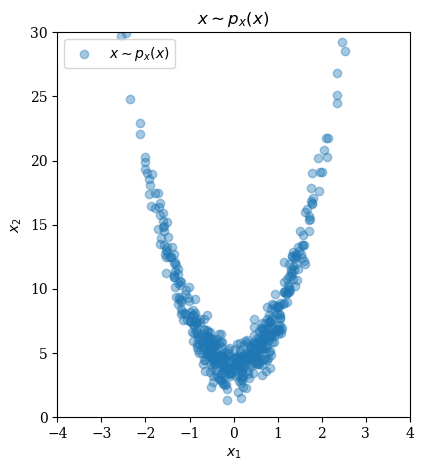

In [3]:
plot_num = 500

fig = figure(figsize=(10,5)); 
subplot(1,2,1); title(L"x \sim p_x(x)")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p_{x}(x)");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();

# Linear inverse problem with Gaussian additive noise

As a stylized example, we will solve an inverse problem given linear measurements of a model $x$ through a compressive sensing operator $A$. We will also add gaussian additive noise and the result will be our observed data.   
$$y = Ax + \epsilon$$

Even though we will chose an $A$ that will be invertible, the added noise makes this problem ill-posed. Therefore for a given datapoint $y$ there is not a single model $x$ which solves the inverse problem. Instead there is a whole distribution of models $p(x|y)$, the conditional distribution. In this context, this is also called the posterior distribution. 

Note: we could also use a non-linear operator.

First we make an our linear measurement operator:

In [4]:
# Random seed
Random.seed!(8)

# Linear forward operator
A = randn(Float32,2,2)
A = A / (2*opnorm(A)); 

noise_lev = 0.2f0

0.2f0

Then use this operator to make training data $Y_{train}$

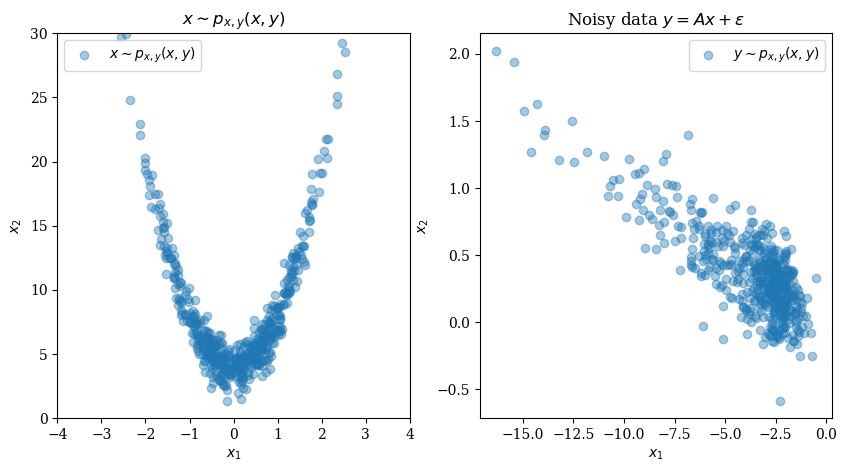

In [5]:
Y_train = reshape(A*reshape(X_train, :, n_train), nx, ny, n_in, n_train)
Y_train += noise_lev*randn(Float32, nx, ny, n_in, n_train)

fig = figure(figsize=(10,5)); 
subplot(1,2,1); title(L"x \sim p_{x,y}(x,y)")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p_{x,y}(x,y)");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();

subplot(1,2,2); title(L"Noisy data $y = Ax + \epsilon$")
scatter(Y_train[1,1,1,1:plot_num], Y_train[1,1,2,1:plot_num]; alpha=0.4, label = L"y \sim p_{x,y}(x,y)");
xlabel(L"x_1"); ylabel(L"x_2");
legend();

## Training a conditional normalizing flow. 

A conditional normalizing flow is trained by learning the joint distribution $p(x,y)$ this is done in the same way as a non-conditional normalizing flow is trained my minimizing the negative log likelihood (Refer to Tutorial notebook 01 for more details. )

In [6]:
function loss(H, X, Y)
    batch_size = size(X)[end] 
    
    Zx, Zy, lgdet = H.forward(X, Y)
    l2_loss = 0.5*norm(tensor_cat(Zx, Zy))^2 / batch_size  #likelihood under Normal Gaussian training 
    
    #gradients under Normal Gaussian training
    dZx = Zx / batch_size 
    dZy = Zy / batch_size 
    
    H.backward(dZx, dZy, Zx, Zy) #sets gradients of G wrt output and also logdet terms
    
    return (l2_loss, lgdet)
end

loss (generic function with 1 method)

In [21]:
# Define network
n_in = 2
n_hidden = 64
batchsize = 64
depth = 8

# Construct HINT network
Random.seed!(1244)
H = NetworkConditionalHINT(n_in, n_hidden, depth; k1=1, k2=1, p1=0, p2=0)

# Training
maxiter = 1000
lr      = 1f-3
lr_decay_step = 90

#compose adam optimizer with exponential learning rate decay 
opt = Flux.Optimiser(ExpDecay(lr, .9f0, lr_decay_step, 1f-6), Flux.Adam(lr))

loss_l2_list    = zeros(maxiter)
loss_lgdet_list = zeros(maxiter)

for j=1:maxiter

    # Evaluate objective and gradients
    X = sample_banana(batchsize)
    Y = reshape(A*reshape(X, :, batchsize), nx, ny, n_in, batchsize)
    Y += noise_lev*randn(Float32, nx, ny, n_in, batchsize)

    losses = loss(H, X, Y)
    loss_l2_list[j]    = losses[1]
    loss_lgdet_list[j] = losses[2]
    
    (j%50==0) && print("Iter : iteration=", j, "/", maxiter, ", batch=", 
            "; f l2 = ",   loss_l2_list[j], 
            "; f lgdet = ",loss_lgdet_list[j], 
            "; f nll objective = ",loss_l2_list[j] - loss_lgdet_list[j], "\n")

    # Update params
    for p in get_params(H)
        Flux.update!(opt, p.data, p.grad)
    end
end

Iter : iteration=50/1000, batch=; f l2 = 2.101518154144287; f lgdet = 0.1383434534072876; f nll objective = 1.9631747007369995
Iter : iteration=100/1000, batch=; f l2 = 2.888096332550049; f lgdet = 0.9780514240264893; f nll objective = 1.9100449085235596
Iter : iteration=150/1000, batch=; f l2 = 1.8194130659103394; f lgdet = 1.074772834777832; f nll objective = 0.7446402311325073
Iter : iteration=200/1000, batch=; f l2 = 2.139436960220337; f lgdet = 1.895308017730713; f nll objective = 0.24412894248962402
Iter : iteration=250/1000, batch=; f l2 = 2.077739715576172; f lgdet = 1.988500952720642; f nll objective = 0.08923876285552979
Iter : iteration=300/1000, batch=; f l2 = 2.093872308731079; f lgdet = 1.5142563581466675; f nll objective = 0.5796159505844116
Iter : iteration=350/1000, batch=; f l2 = 2.142843723297119; f lgdet = 1.7741684913635254; f nll objective = 0.36867523193359375
Iter : iteration=400/1000, batch=; f l2 = 1.6341756582260132; f lgdet = 2.075113534927368; f nll objecti

## Check training objective log 
There are various ways to train a NF:
- train your network to convergence of objective
- use earlystopping to prevent overfitting 
- check normality of $Zx, Zy = H_{\theta}(Z,Y)$ with qq plots 
- as a heuristic simply observe $Zx, Zy = H_{\theta}(X, Y)$ until it looks normal under the eyeball norm. 

Note: joint distributions are harder to learn than marginal distributions. There are a few reasons including the larger dimensionality and the fact that learning a joint distribution implicitly also learns a conditional distribution. 

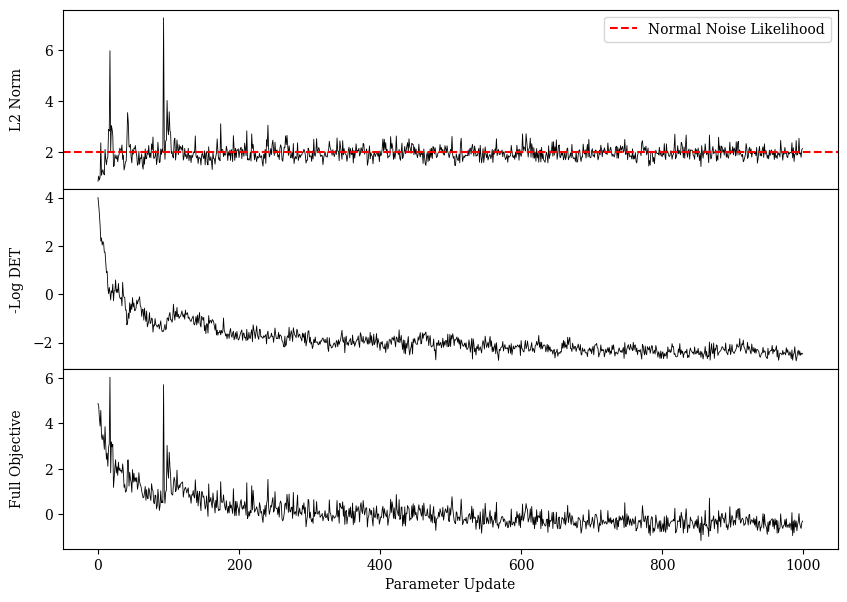

PyObject Text(0.5, 24.000000000000007, 'Parameter Update')

In [22]:
gt_l2 = 0.5*nx*ny*n_in*2 #l2 norm of noise. Note: extra 2 factor since learning a 2 rv. joint distribution

fig, axs = subplots(3, 1, sharex=true, figsize=(10,7))
fig.subplots_adjust(hspace=0)

axs[1].plot(loss_l2_list, color="black", linewidth=0.6); 
axs[1].axhline(y=gt_l2,color="red",linestyle="--",label="Normal Noise Likelihood")
axs[1].set_ylabel("L2 Norm")
axs[1].yaxis.set_label_coords(-0.05, 0.5)
axs[1].legend()

axs[2].plot(-loss_lgdet_list, color="black", linewidth=0.6); 
axs[2].set_ylabel("-Log DET") 
axs[2].yaxis.set_label_coords(-0.05, 0.5) 

axs[3].plot(loss_l2_list - loss_lgdet_list, color="black", linewidth=0.6); 
axs[3].set_ylabel("Full Objective") 
axs[3].yaxis.set_label_coords(-0.05, 0.5)
axs[3].set_xlabel("Parameter Update") 

## Test inference of inverse problem given noisy data

After verifying that training was successful we can proceed to perform inference of the inverse problem. We will first observe a single data $y$:

In [33]:
x_star  = sample_banana(1);
y_obs = reshape(A*vec(x_star), nx, ny, n_in, 1);
y_obs += noise_lev*randn(Float32, size(y_obs));

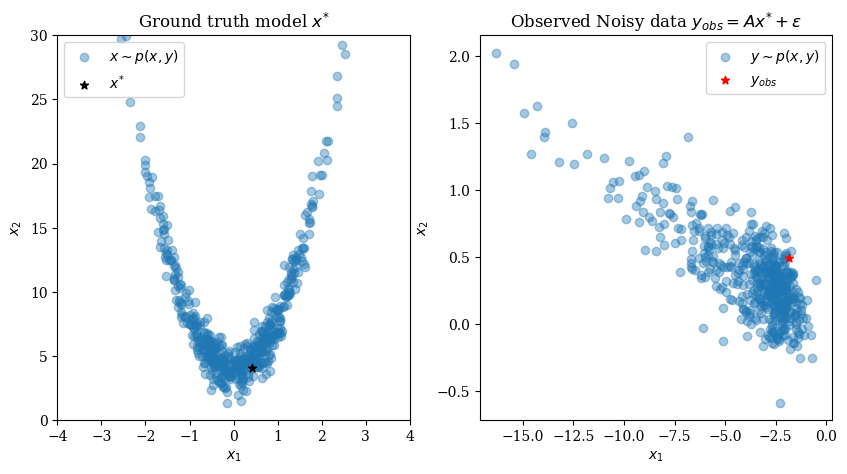

In [34]:
fig = figure(figsize=(10,5)); 
subplot(1,2,1); title(L"Ground truth model $x^{*}$")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p(x,y)");
scatter(x_star[1,1,1,1], x_star[1,1,2,1]; marker="*", color="black", label = L"x^{*}");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();

subplot(1,2,2); title(L"Observed Noisy data $y_{obs} = Ax^{*} + \epsilon$")
scatter(Y_train[1,1,1,1:plot_num], Y_train[1,1,2,1:plot_num]; alpha=0.4, label = L"y \sim p(x,y)");
scatter(y_obs[1,1,1,1], y_obs[1,1,2,1]; marker="*", color="red", label = L"y_{obs}");
xlabel(L"x_1"); ylabel(L"x_2");
legend();

## Form conditional distribution given observed data $p(x|y_{obs})$

Remember that the y-lane in HINT is completely independent of the x-lane. This functionality is implemented in  ``H.forward_Y`` which we will call on our observed data to get the corresponding latent variable $z_y$.


In [35]:
zy_fixed = H.forward_Y(y_obs);

Then we can sample directly from the conditional aka posterior distribution $x \sim p(x|y_{obs})$ We do this by resampling $z_x \sim N(0,I)$ and calling the inverse network $H^{-1}(z_x, z_y)$

In [36]:
#fix zy and resample zx many times to generate samples from the conditional distribution p(x|y)
cond_sampling_size = 50
Zx = randn(Float32, nx, ny, n_in, cond_sampling_size)
X_post = H.inverse(Zx, zy_fixed.*ones(Float32, nx, ny, n_in, cond_sampling_size))[1];

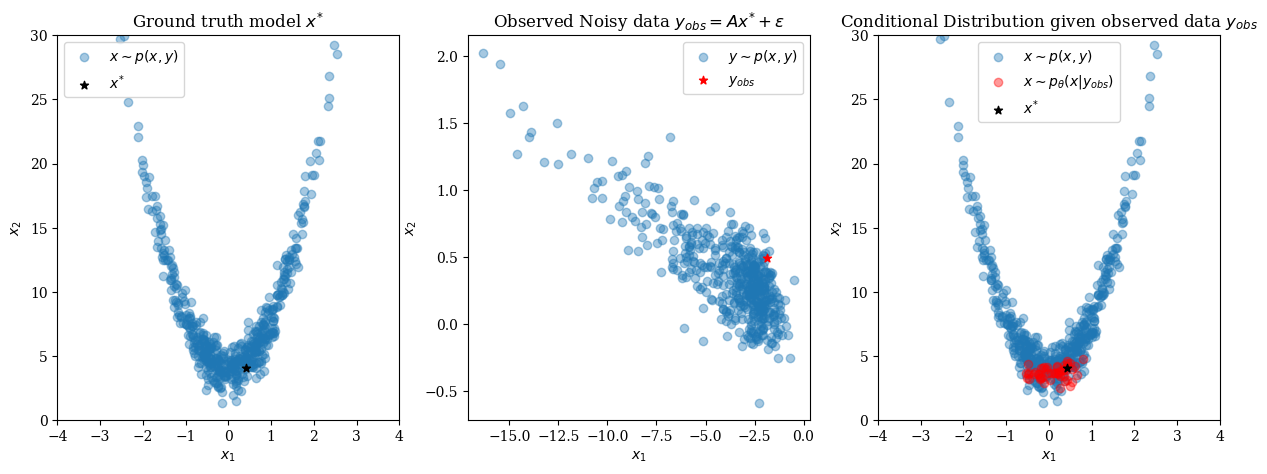

PyObject <matplotlib.legend.Legend object at 0x2aeeccd30>

In [37]:
fig = figure(figsize=(15,5)); 
subplot(1,3,1); title(L"Ground truth model $x^{*}$")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p(x,y)");
scatter(x_star[1,1,1,1], x_star[1,1,2,1]; marker="*", color="black", label = L"x^{*}");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();

subplot(1,3,2); title(L"Observed Noisy data $y_{obs} = Ax^{*} + \epsilon$")
scatter(Y_train[1,1,1,1:plot_num], Y_train[1,1,2,1:plot_num]; alpha=0.4, label = L"y \sim p(x,y)");
scatter(y_obs[1,1,1,1], y_obs[1,1,2,1]; marker="*", color="red", label = L"y_{obs}");
xlabel(L"x_1"); ylabel(L"x_2");
legend();

subplot(1,3,3); title(L"Conditional Distribution given observed data $y_{obs}$")
scatter(X_train[1,1,1,1:plot_num], X_train[1,1,2,1:plot_num]; alpha=0.4, label = L"x \sim p(x,y)");
scatter(X_post[1,1,1,:], X_post[1,1,2,:]; alpha=0.4, color="red", label = L"x \sim p_{\theta}(x | y_{obs})");
scatter(x_star[1,1,1,1], x_star[1,1,2,1]; marker="*",color="black",  label = L"x^{*}");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend()